In [1]:
from fastai.structured import *
from fastai.column_data import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# lets load the data
df = pd.read_csv('course_ratings.csv')

In [3]:
#lets remove high rating rows
joined = df.drop(df[df['rating'] > 5].index)

In [4]:
# lets define catigorical vars
cat_vars = ['user','course','category','job','institution','state']
#coninuous vars
cont_vars = ['rating']

# df length
n = len(df)

# test percentage
testp = n*.2

#lets update features, categoricial should be category and continuous should be float32
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()
    
for v in cont_vars:
    joined[v] = joined[v].fillna(0).astype('float32')

In [5]:
# we have to convert all category variables into contiguous ones and save the look up table
lookup_table = {}
for c in cat_vars:
    uq = joined[c].unique()
    col2idx =  {o:i for i,o in enumerate(sorted(uq))}
    lookup_table[c] = col2idx
    joined[c] = joined[c].apply(lambda x: col2idx[x])

In [6]:
# create a test/train set split
joined, joined_test = train_test_split(joined, test_size=0.25)
df = joined.drop('rating', axis=1)
y = joined['rating']
df_test = joined_test.drop('rating', axis=1)

# create a validation set of ids
train_ratio = 0.75
train_size = int(len(df) * train_ratio)
val_idx = list(range(train_size, len(df)))

In [7]:
#final df , everything is numeric and continguous
df.head(10)

,user,course,category,job,institution,state
41048,51063,61,11,29,11,30
46996,41967,174,7,6,11,5
143447,32505,28,7,6,11,41
108864,40033,70,0,28,11,30
118686,35442,171,7,6,9,30
15173,51129,172,7,6,0,24
7088,45562,172,7,6,14,24
155733,26602,174,7,44,14,30
33243,50147,71,8,6,11,24
134300,43883,179,7,6,8,39


In [8]:
#lets build the initial model
md = ColumnarModelData.from_data_frame("models/", val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=128, test_df=df_test)

In [9]:
#build embedding matrix, matrices should be 1 bigger then the the number of categorical options to leave room for unknown
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(52118, 50), (220, 50), (15, 8), (46, 23), (16, 8), (61, 31)]

In [10]:
#build the learner, 
# .04 dropout on the embedding matrix
# 1000 and 500 nodes on 2 different layers
# .001 and .01 dropouts
# specifying the range of y (rating) to be 0-5
m = md.get_learner(emb_szs,0 ,0.04, 1, [1000,500], [0.001,0.01],y_range=(0,5))

In [12]:
m.summary()

TypeError: torch.index_select received an invalid combination of arguments - got ([32;1mtorch.cuda.FloatTensor[0m, [32;1mint[0m, [31;1mtorch.cuda.FloatTensor[0m), but expected (torch.cuda.FloatTensor source, int dim, torch.cuda.LongTensor index)

In [13]:
#lets find a learning rate
m.lr_find()

 81%|████████  | 622/771 [00:05<00:01, 110.22it/s, loss=1.22] 


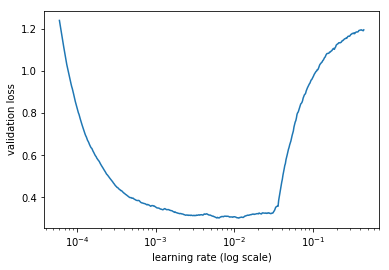

In [38]:
m.sched.plot(100)

In [14]:
lr = 1e-3

In [15]:
# lets fit the model, 50 epochs with restarts
m.fit(lr, 50, cycle_len=5)

epoch      trn_loss   val_loss                                
    0      0.251065   0.231956  
    1      0.178752   0.21344                                 
    2      0.133683   0.214341                                
    3      0.10436    0.216699                                 
    4      0.082238   0.221261                                 
    5      0.126928   0.235749                                 
    6      0.096233   0.228888                                 
    7      0.060322   0.232883                                 
    8      0.034411   0.234541                                 
    9      0.026437   0.239289                                 
    10     0.051319   0.246238                                 
    11     0.055719   0.236999                                 
    12     0.02624    0.2341                                   
    13     0.01419    0.23754                                  
    14     0.009872   0.237952                                  
    15   

   125     0.002605   0.229087                                  
   126     0.00414    0.229245                                  
   127     0.003094   0.230052                                  
   128     0.001843   0.229297                                  
   129     0.001567   0.229079                                  
   130     0.003467   0.233588                                  
   131     0.004405   0.232756                                  
   132     0.002716   0.23063                                   
   133     0.001832   0.22959                                   
   134     0.001606   0.229717                                  
   135     0.002716   0.231145                                  
   136     0.003637   0.230791                                  
   137     0.002629   0.230705                                  
   138     0.00189    0.229982                                  
   139     0.001468   0.229555                                  
   140     0.002544   0.2

[array([0.23408])]

In [16]:
m.save('mdl')

In [17]:
m.load('mdl')

In [18]:
x,y=m.predict_with_targs()

In [19]:
pred_test=m.predict(is_test=True)

In [20]:
joined_test['rating_pred'] = pred_test

In [21]:
joined_test[['rating','rating_pred']]

,rating,rating_pred
162965,4.32,4.679566
25625,2.81,2.713656
98341,4.08,4.300858
138086,3.18,3.726358
348,4.19,4.097975
59636,3.77,3.660269
7638,4.59,4.699990
40669,4.58,4.631374
40279,4.50,3.936749
83116,4.42,4.038456


In [22]:
rms = sqrt(mean_squared_error(joined_test['rating'], joined_test['rating_pred']))

In [23]:
# we achieved a root mean squared error of .48
rms

0.48265219993287534

In [24]:
test_record = df_test.iloc[0]

In [25]:
joined_test.iloc[0]

user             18277
course              82
category            11
rating            4.32
job                 12
institution          0
state               57
rating_pred    4.67957
Name: 162965, dtype: object

In [26]:
cat = test_record[cat_vars].values.astype(np.int64)[None]
contin = test_record.drop(cat_vars).values.astype(np.float32)[None]

#Prediction
model = m.model
model.eval()
prediction = to_np(model(V(cat),[]))

In [27]:
prediction[0][0]

4.679566